# CEAPS Data Forecasting

This project aims to analyze the CEAPS(Cota para Exercício da Atividade Parlamentar dos Senadores - Quota for the Exercise of Parliamentary Activity by Senators) data(2008-2022) in order to generate insides over it.

This file focus on the forecasting, where we try to foresee how the data will behave in the future, given the historical data we have available. 

For this, a different dataset will be used, 'dataset_ceaps_forecasting.csv'. It is a compiled version of the 'despesa_ceaps_2008_2022_formatted.csv', that takes data from 2018 onwards and groups the values by date of reimbursement and display the sum of the reimbursed values for that date. The idea is to identify how much the senators are going to expend in the next months.

## The base line

Starting from a simple approach, taking the mean of the latest months and projecting that to the future months.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px

In [2]:
data = pd.read_csv('dataset_ceaps_forecasting.csv')
data

ds          y
0     2018-01-01   13062.46
1     2018-01-02   61972.66
2     2018-01-03   54424.44
3     2018-01-04   21775.57
4     2018-01-05   41703.32
...          ...        ...
1456  2021-12-27   28552.41
1457  2021-12-28  154547.27
1458  2021-12-29   22495.76
1459  2021-12-30  118345.56
1460  2021-12-31   27219.41

[1461 rows x 2 columns]

In [3]:
data['ds'] = pd.to_datetime(data['ds'], format='%Y-%m-%d')

In [4]:
last_three_months_mean = data[data['ds'] > '2021-09-30']['y'].mean()
last_three_months_mean

75787.79913043477

So we have a mean of 75787.79 on the last three months on 2021.

Let's load the data from 2022 and compare.

## Loading 2022 data

In [5]:
data2022 = pd.read_csv('despesa_ceaps_2022.csv', encoding='ISO-8859-1', sep=';', skiprows=1)

We need to do some formatting so we can easily compare the datasets.

In [6]:
data2022['DATA'] = pd.to_datetime(data2022['DATA'], format='%d/%m/%Y', errors='coerce')
data2022['VALOR_REEMBOLSADO'] = data2022['VALOR_REEMBOLSADO'].str.replace(',', '.', regex=False).replace(r'[^0-9.]', '', regex=True)
data2022['VALOR_REEMBOLSADO'] = data2022['VALOR_REEMBOLSADO'].astype(np.float32)
data2022_filtered = data2022[(data2022['DATA'] >= '2022-01-01') & (data2022['DATA'] <= '2022-12-31')]
data2022_formatted = data2022_filtered.groupby(['DATA'])[['VALOR_REEMBOLSADO']].sum().reset_index()
data2022_formatted = data2022_formatted.rename(columns={'DATA': 'ds', 'VALOR_REEMBOLSADO': 'y'})
data2022_formatted.head()

ds             y
0 2022-01-01  31556.259766
1 2022-01-02  19811.910156
2 2022-01-03  80614.906250
3 2022-01-04  63580.199219
4 2022-01-05  56411.437500

Now that we have the 2022 data in the same format as our original DF from 2018-2021, we can compare the models from the original to the 'future' data.

## Comparing 2021 and 2022 on base line model

If we get the mean of the first 3 months of 2022, we do get a similar value as the one we got from 2021, R$75787.79.

In [7]:
data2022_formatted.query('ds < "2022-04-01"')['y'].mean()

72026.21

Although, if we get just the first month of 2022 for comparison, very different values.

In [8]:
data2022_formatted.query('ds < "2022-02-01"')['y'].mean()

48591.684

Although, need to consider the finding from the Data Analysis previously done, where January is the month with less expenses entries, consequense of recess and holidays period in Brazil.

Not even the mean from Dezember 2021 would be similar to January 2022:

In [9]:
data[data['ds'] > '2021-11-30']['y'].mean()

77830.20096774194

Another thing we could notice is that the expenses have been increasing since the low period of 2020, where we ended 2022 with an expense higher than on 2018/19.

So, if we get the mean of each year since 2018 to 2022, we should see how the values got to a bottom on 2020 and raised to a peak on 2022.

In [10]:
mean2018 = data.query('ds >= "2018-01-1" & ds <= "2018-12-31"')['y'].mean()
mean2019 = data.query('ds >= "2019-01-1" & ds <= "2019-12-31"')['y'].mean()
mean2020 = data.query('ds >= "2020-01-1" & ds <= "2020-12-31"')['y'].mean()
mean2021 = data.query('ds >= "2021-01-1" & ds <= "2021-12-31"')['y'].mean()
mean2022 = data2022_formatted['y'].mean()
years = [2018, 2019, 2020, 2021, 2022]
means = [mean2018, mean2019, mean2020, mean2021, mean2022]

fig = px.bar(x = years, y=means, labels={'x': 'Years', 'y': 'Means'}, title='Expenses means per year since 2018')
fig.show()

That scenario makes it hard to workout a predictive model from 2018-2021, as values from 2017-2019 where kind stable, 2020's chaos was not expected and 2021 was a recoverying year.

If we ignore 2020 though, we migh be able to see a smooth evolution from 2018 to 2022, and simple "means" prediction would not present itself so out of the curve over 2022 higher value.

In [11]:
years = [2018, 2019, 2021, 2022]
means = [mean2018, mean2019, mean2021, mean2022]

fig = px.bar(x = years, y=means, labels={'x': 'Years', 'y': 'Means'}, title='Expenses means per year since 2018',)
fig.show()

Although, this is a very simplist approach.

## Forecasting with Prophet

Prophet speciality is prediction over a time series. It should perform better the more extensive the data is, so although I am using here data from 2018-2021, it would be interesting to see the difference later on if we get data since 2008 for example.

Also, will be interesting to see how it behaves around 2020, where the data shifted.

In [12]:
from prophet import Prophet

In [13]:
m = Prophet()
m.fit(data)

07:00:07 - cmdstanpy - INFO - Chain [1] start processing
07:00:07 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
future = m.make_future_dataframe(periods=31)
future.tail()

ds
1487 2022-01-27
1488 2022-01-28
1489 2022-01-29
1490 2022-01-30
1491 2022-01-31

In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat    yhat_lower     yhat_upper
1487 2022-01-27   82911.048845  30475.335562  131927.825476
1488 2022-01-28   73108.128463  23439.295264  123891.613307
1489 2022-01-29   24943.125257 -25004.469253   77400.084159
1490 2022-01-30   21603.146236 -30324.966090   70502.906049
1491 2022-01-31  107391.378345  55203.494141  157174.723321

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



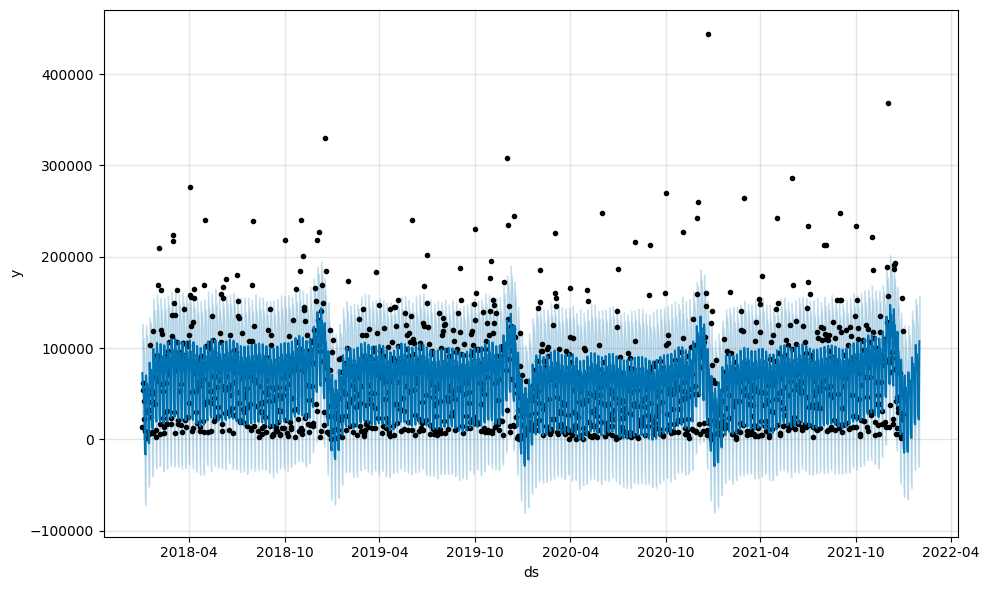

In [16]:
fig1 = m.plot(forecast)

In [17]:
forecast.query('ds > "2021-12-31"')['yhat'].mean()

49512.08146438716

If we take the value above, R$49512.08, forecasted from the historical data from 2018-2021 for January 2022, that is incredibly close to the real data mean we got before, R$48591.68. And that was just working with 4 years of historical data. Imagine how precise it can get with data from 2008 onwards in it.

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old beh

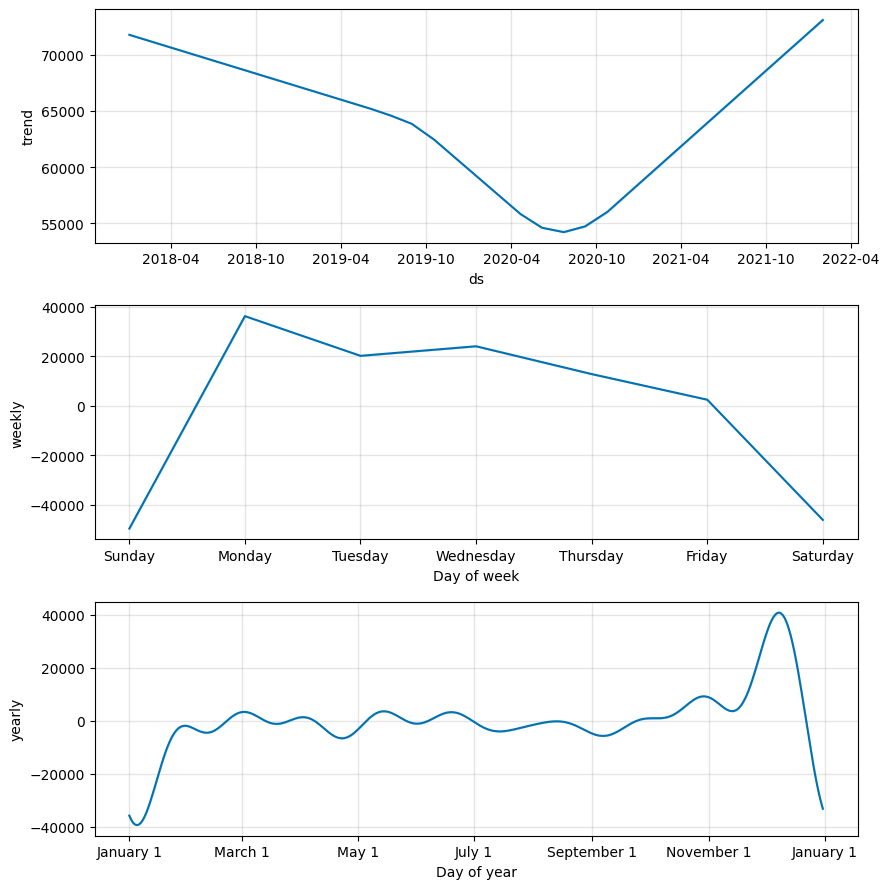

In [18]:
fig2 = m.plot_components(forecast)

Looking at the trends charts, we can see a confirmation of all the analysis we did previously. The decrease of expenses from 2018-2020 and the raise of it after 2021. The reduced expenses on Dezember-January. And another that makes sence we did not see is the low expenses on Saturdays and Sundays.

Although the temporal series did not contain the 2022 data, it was predicted, we can see on the first chart that it expects a higher expense than on 2018, which is correct if you remind the analysis we did previsouly.

### Interactive charts with Plotly

We can plot Prophet's charts using plotly to get an interactive experience instead:

In [19]:
from prophet.plot import plot_plotly, plot_components_plotly

In [20]:
plot_plotly(m, forecast)

In [21]:
plot_components_plotly(m, forecast)

## Addressing negative values on Prophet charts

Although Prophet did a pretty good job predicting values from our data using default configuration, we can see it did generate some negative values on the trends and general prediction. They do represent the behavior we have generically speaking, but the negative values should not be there.

First thing to try would be giving boundaries to it using logistic growth.

In [24]:
df_growth = data.copy()

# Add the boundaries
df_growth['cap'] = df_growth['y'].max()
df_growth['floor'] = 0

In [25]:
model = Prophet(growth='logistic')
model.fit(df_growth)

07:33:29 - cmdstanpy - INFO - Chain [1] start processing
07:33:29 - cmdstanpy - INFO - Chain [1] done processing


/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



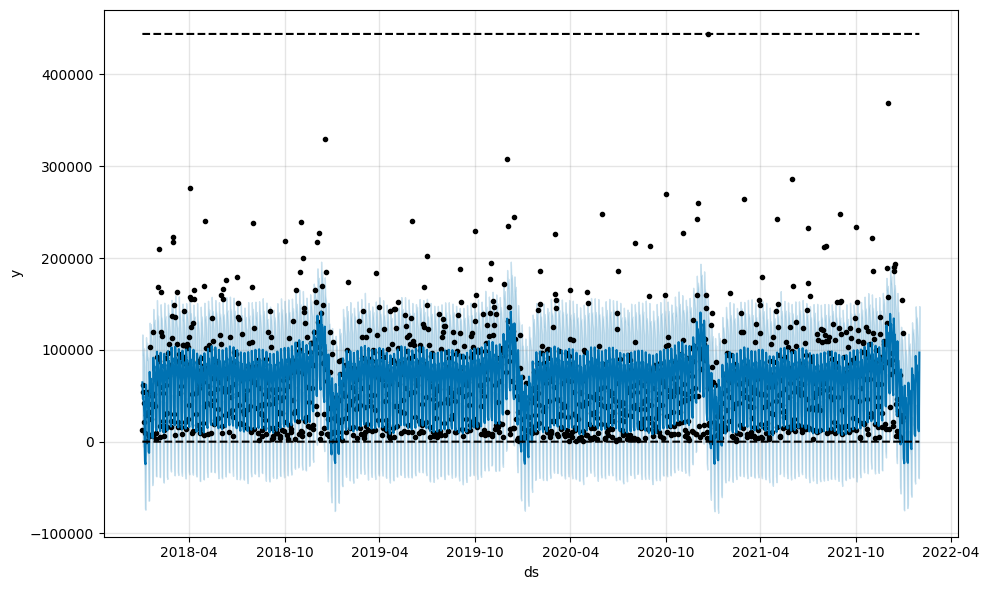

In [26]:
future = model.make_future_dataframe(periods=31)
future['cap'] = df_growth['cap'].max()
future['floor'] = 0

forecast = model.predict(future)

fig = model.plot(forecast)

And apparently there was no effect on the negative values.

Let's check the trends.

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old beh

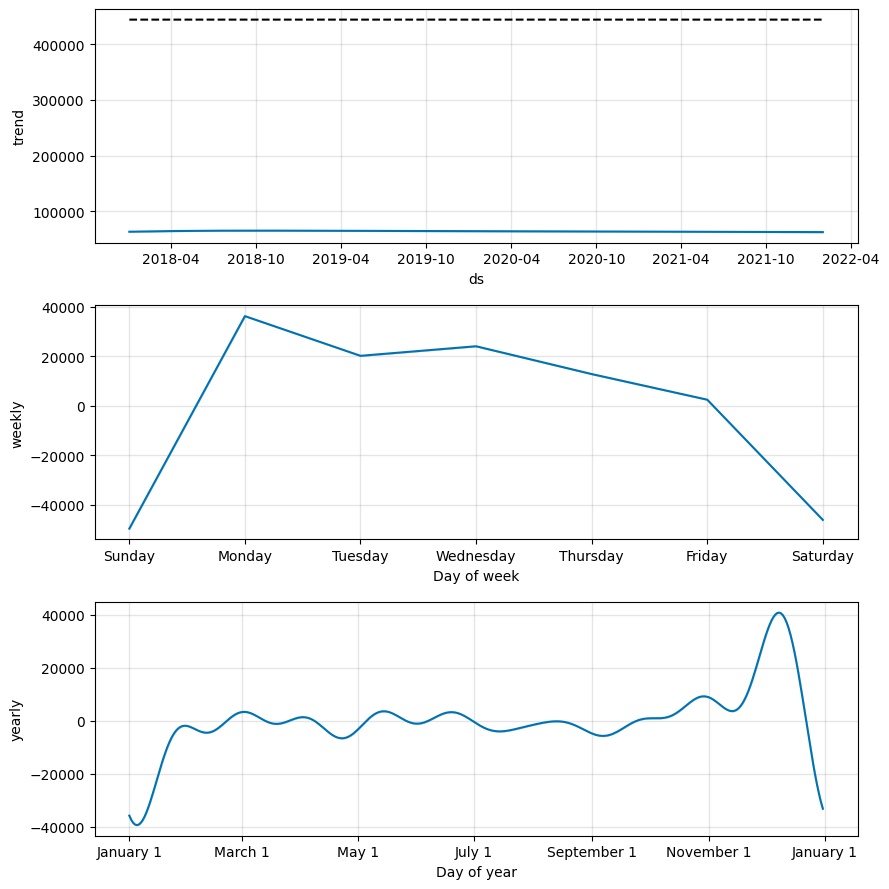

In [27]:
fig2 = m.plot_components(forecast)

Yes, definetely not a progress.

Let's try another approach, with logaritmic transformation of values before applying them to the model, and on the forecast data we reverse the transformation.

07:42:56 - cmdstanpy - INFO - Chain [1] start processing
07:42:56 - cmdstanpy - INFO - Chain [1] done processing
/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



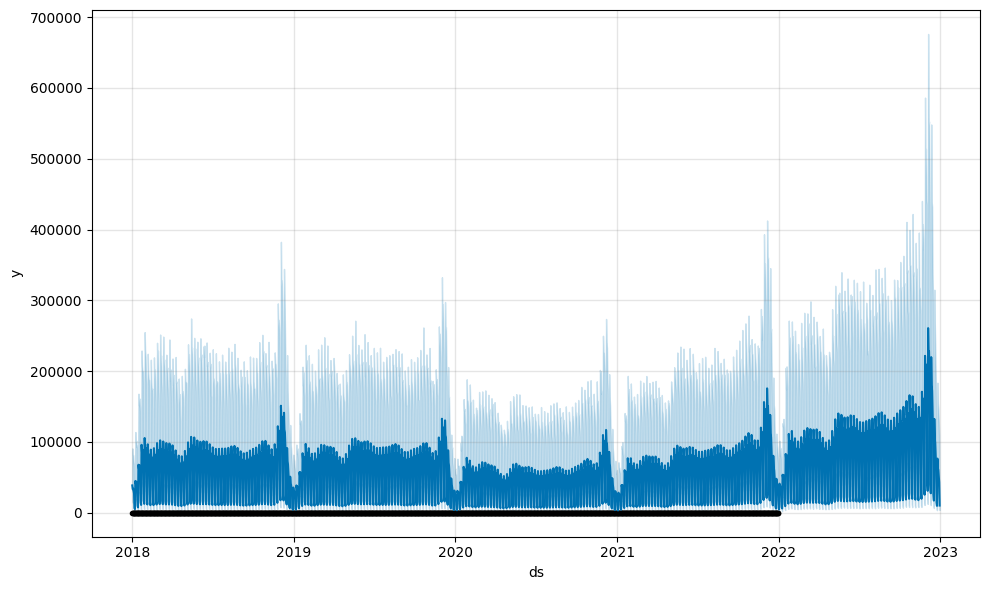

In [28]:
df_log = data.copy()

# Log transform values
df_log['y'] = np.log(df_log['y'])

model = Prophet()
model.fit(df_log)

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Reverse the log transformation
forecast['yhat'] = np.exp(forecast['yhat'])
forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])

fig = model.plot(forecast)

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/fernandowolff/anaconda3/envs/datasciencepython/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old beh

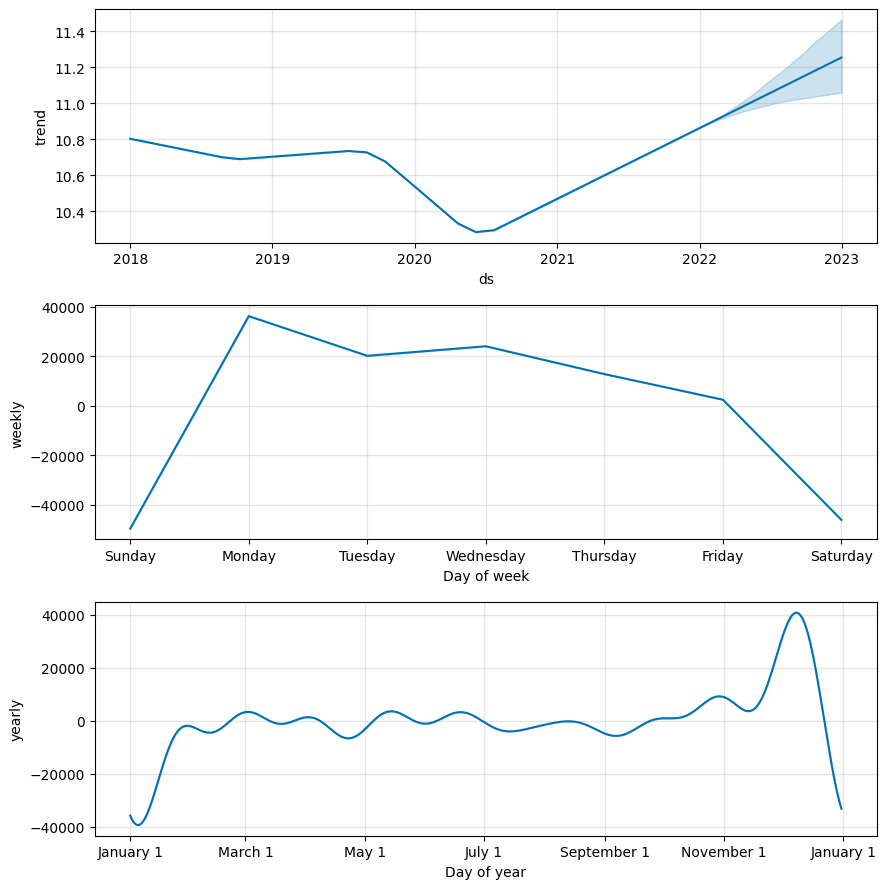

In [29]:
fig2 = m.plot_components(forecast)

Although the main prediction chart kind did not include negative values, we see the negative value in the outliers all grouped on the X axis, the weekly and yearly trends still display values below 0.

A little research made me aware of some possible causes to that. Two of them that makes more sense to me would be:
- The model's flexibility, as Prophet is designed to handle a wide range of time series, including periods with complex seasonal patterns, can lead to overfitting or generation of negative values in the predictions.
- The yearly and weekly seasonal components are modeled as smooth functions (usually Fourier series), that might extrapolate to negative values if the data has strong seasonal effects.

At the point of writting this, I am still learning data analysis and statistics in general, so, unfortunately, the complete understanding of this behavior will be for the me of the future to obtain. Although, if you have the answer, please share with me, I'll appreciate.